# Домашнее задание 2
- Обучить полносвязную модель на MNIST
- Обучить глубокую сверточную сеть на MNIST
- *обучить с нуля глубокую сеть на небольшом датасете. Сравнить результат с дообучением предобученной сети


In [20]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Задание 1
Обучить полносвязную модель на MNIST

### Архитектура модели

In [22]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.2):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        nn.init.xavier_normal_(self.linear1.weight)         # Инициализация весов
        self.activation1 = nn.Sigmoid()
        self.do1 = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.activation2 = nn.Sigmoid()
        self.do2 = nn.Dropout(dropout_p)
        self.linear3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):                                   # на форвард приходят фичи x - картинка, вытянутая в вектор
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.do1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.do2(x)
        x = self.linear3(x)     

        return x

### Загрузчик данных

In [23]:
# без разделения на тестовую и обучающую выборки
#dataset = datasets.MNIST('.', download=True)

In [24]:
# скачивание обучающего датасета
dataset_train = datasets.MNIST('.', train=True, download=True)

# скачивание тестового датасета
dataset_test = datasets.MNIST('.', train=False, download=True)

### Формирование батча

In [25]:
def collate_fn(data: list):   # collate_fn принимает на вход список элементов датасета
                              # которые складываются в торчтензоры (удобно передавать их в словарь),
                              # в котором под ключем data лежат упакованные в батч картинки,
                              # под ключем target - в том же порядке соответствующие таргеты
  # data = [(pic, target)...]
  
  # в цикле формируются списки с картинками и таргетами для каждого индекса, поданного на вход  
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  
  # картинки преобразовываются в торчтензор, который имеет размер батч x ширина x высота
  # нормирование данных (интенсивность 0-255 приводится к 0-1)
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H или Батч x 784
  target = torch.from_numpy(numpy.array(target))

  return {'data': pics.view(pics.size(0), -1), # преобразуем матрицу 28х28 в вектор 784 (линейный слой не работает с матрицами)
          'target': target.long(),
          }

### Гиперпараметры

In [26]:
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'mps' if device_id == -1 else f'cuda:{device_id}' # 'cuda:1' id GPU
n_epochs = 20
batch_size = 128

### Инициализация модели, задание оптимизатора и функции потерь

In [27]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
optim = torch.optim.Adam(model.parameters()) # Adam с параметрами по умолчанию
loss_func = nn.CrossEntropyLoss()   # функция потерь CrossEntropyLoss (для многоклассовой классификации)

### Трейн луп

In [28]:
# для каждой эпохи
for epoch in range(n_epochs):
    
    # случайное разбиение обучающей выборки на батчи
    trainloader = DataLoader(dataset_train, 
                             batch_size,
                             shuffle=True, 
                             collate_fn=collate_fn, 
                             drop_last = True)
    
    # перевод модель в режим обучения
    model.train()
    # итератор по батчам (у метода DataLoader)
    for i, batch in enumerate(trainloader):
        # обнуление градиентов (в торче они накапливаются с каждым бэквордом)
        optim.zero_grad()
        # передача в модель батча - выполнение предсказания
        predict = model(batch['data'].to(device))
        # расчет функции потерь (по предсказанию и таргету батча)
        loss = loss_func(predict, batch['target'].to(device))
        # расчет градиентов (в торче работает autograd)
        loss.backward()
        # обновление весов (встроенный в оптимизатор метод)
        optim.step()
        # каждые 200 шагов выводим статистику по модели
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss_dataset_train: {loss.item()}')
    
    # случайное разбиение тестовой выборки на батчи
    testloader = DataLoader(dataset_test, 
                            batch_size=len(dataset_test.data),
                            shuffle=True, 
                            collate_fn=collate_fn, 
                            drop_last = False)
    
    # перевод модель в режим инференса
    model.eval()
    for i, batch in enumerate(testloader):
        # передача в модель батча (батч 1) - выполнение предсказания        
        predict = model(batch['data'].to(device))
        # расчет функции потерь (по предсказанию и таргету батча)
        loss = loss_func(predict, batch['target'].to(device))
        # выводим loss по тестовой выборке
        print(f'epoch: {epoch}, loss_dataset_test: {loss.item()}')
        print()

epoch: 0, step: 0, loss_dataset_train: 2.3273849487304688
epoch: 0, step: 200, loss_dataset_train: 0.44924288988113403
epoch: 0, step: 400, loss_dataset_train: 0.3409607410430908
epoch: 0, loss_dataset_test: 0.27338212728500366

epoch: 1, step: 0, loss_dataset_train: 0.2593865692615509
epoch: 1, step: 200, loss_dataset_train: 0.2722008228302002
epoch: 1, step: 400, loss_dataset_train: 0.2623645067214966
epoch: 1, loss_dataset_test: 0.19757750630378723

epoch: 2, step: 0, loss_dataset_train: 0.10369203239679337
epoch: 2, step: 200, loss_dataset_train: 0.196613609790802
epoch: 2, step: 400, loss_dataset_train: 0.12480802834033966
epoch: 2, loss_dataset_test: 0.1541953682899475

epoch: 3, step: 0, loss_dataset_train: 0.18442487716674805
epoch: 3, step: 200, loss_dataset_train: 0.14036999642848969
epoch: 3, step: 400, loss_dataset_train: 0.12086138129234314
epoch: 3, loss_dataset_test: 0.1275346726179123

epoch: 4, step: 0, loss_dataset_train: 0.10452403873205185
epoch: 4, step: 200, loss_

Loss для тестовой выборки значительно больше, чем для обучающей (что логично для распознавания картинок линейным слоем)

### Посмотрим результаты предсказания на обучающей выборке и на тестовой выборках

In [29]:
# Функция вывода по номеру элемента (может быть случайным) изображения предсказанного и реального значения
def result(train_or_test, n_item=None):
    if train_or_test == "train":
        if n_item == None:
            n_item = torch.randint(0, len(dataset_train)-1, (1, 1)).squeeze().tolist()
        else:
            n_item = n_item
        image = dataset_train.data[n_item].detach().numpy()
        data = dataset_train.data[n_item].unsqueeze(0).view(1, -1).to(device).float()
        target = dataset_train.targets[n_item].tolist()
        print(f"Обучающая выборка, элемент № {n_item}")
    elif train_or_test == "test":
        if n_item == None:
            n_item = torch.randint(0, len(dataset_test)-1, (1, 1)).squeeze().tolist()
        else:
            n_item = n_item
        image = dataset_test.data[n_item].detach().numpy()
        data = dataset_test.data[n_item].unsqueeze(0).view(1, -1).to(device).float()
        target = dataset_test.targets[n_item].tolist()
        print(f"Тестовая выборка, элемент № {n_item}")
    else:
        print("Нужно указать датасет: 'train' или 'test'") 
    if train_or_test == "train" or train_or_test == "test":       
        model.eval()
        plt.imshow(image)
        plt.show()
        predict = torch.argmax(model(data)).squeeze().cpu().detach().tolist()
        print(f"predict: {predict}")
        print(f"true:    {target}")

Обучающая выборка, элемент № 13077


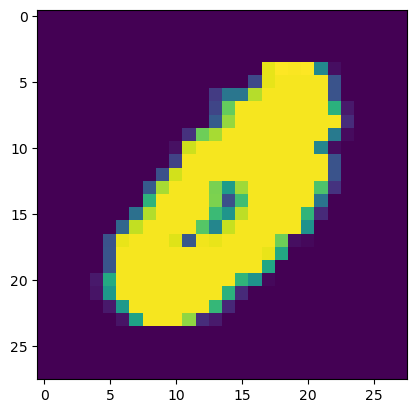

predict: 0
true:    0


In [30]:
result('train')

Тестовая выборка, элемент № 5129


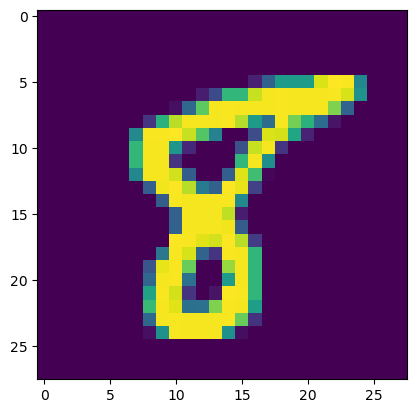

predict: 8
true:    8


In [31]:
result('test')

Посчитаем количество неправильно предсказанных элементов на обучающей и на тестовой выборках

In [33]:
uncorrect_items = []
with torch.no_grad():
    model.eval()
    for i in range(len(dataset_train)):
        target_predict = torch.argmax(model(dataset_train.data[i].unsqueeze(0).view(1, -1).to(device).float())).squeeze().cpu().detach().tolist()
        target_true = dataset_train.targets[i].tolist()
        if target_predict != target_true:
            uncorrect_items.append(i)
print(f"Общее количество элементов обучающей выборки:                        {len(dataset_train)}")
print(f"Количество неправильно предсказанных элементов на обучающей выборке: {len(uncorrect_items)}")
print(f"Процент правильно предсказанных элементов на обучающей выборке:      {(1-len(uncorrect_items)/len(dataset_train)):.2%}")

Общее количество элементов обучающей выборки:                        60000
Количество неправильно предсказанных элементов на обучающей выборке: 395
Процент правильно предсказанных элементов на обучающей выборке:      99.34%


In [34]:
uncorrect_items = []
with torch.no_grad():
    model.eval()
    for i in range(len(dataset_test)):
        target_predict = torch.argmax(model(dataset_test.data[i].unsqueeze(0).view(1, -1).to(device).float())).squeeze().cpu().detach().tolist()
        target_true = dataset_test.targets[i].tolist()
        if target_predict != target_true:
            uncorrect_items.append(i)
print(f"Общее количество элементов тестовой выборки:                        {len(dataset_test)}")
print(f"Количество неправильно предсказанных элементов на тестовой выборке: {len(uncorrect_items)}")
print(f"Процент правильно предсказанных элементов на тестовой выборке:      {(1-len(uncorrect_items)/len(dataset_test)):.2%}")
print("Номера неправильно предсказанных элементов на тестовой выборке:")
print(uncorrect_items)

Общее количество элементов тестовой выборки:                        10000
Количество неправильно предсказанных элементов на тестовой выборке: 223
Процент правильно предсказанных элементов на тестовой выборке:      97.77%
Номера неправильно предсказанных элементов на тестовой выборке:
[73, 115, 199, 247, 259, 266, 274, 321, 340, 381, 391, 445, 495, 582, 674, 691, 710, 720, 900, 944, 947, 951, 965, 1003, 1014, 1039, 1044, 1112, 1128, 1156, 1182, 1226, 1232, 1242, 1247, 1281, 1289, 1299, 1319, 1328, 1378, 1393, 1395, 1414, 1522, 1530, 1549, 1553, 1554, 1678, 1681, 1709, 1717, 1790, 1800, 1901, 1941, 1984, 2004, 2016, 2024, 2029, 2035, 2040, 2053, 2070, 2073, 2093, 2118, 2135, 2162, 2182, 2189, 2272, 2339, 2369, 2387, 2406, 2414, 2454, 2462, 2488, 2514, 2582, 2597, 2648, 2654, 2720, 2743, 2758, 2810, 2877, 2896, 2921, 2927, 2939, 2970, 3073, 3115, 3117, 3206, 3422, 3441, 3503, 3520, 3533, 3549, 3558, 3567, 3597, 3604, 3629, 3662, 3702, 3749, 3751, 3757, 3767, 3776, 3780, 3811, 3838, 3853, 

# Задание 2
Обучить глубокую сверточную сеть на MNIST

### Архитектура модели

In [56]:
class ConvModel(nn.Module):
  def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.2):
    super().__init__()
    # уменьшит размер картинки в 2 раза
    self.conv1 = nn.Conv2d(input_ch, hidden_ch, kernel_size=5, padding=2, stride=2) # число каналов на входе 
                                                                                    # число каналов на выходе
                                                                                    # размер ядра, размер паддинга и страйд
    self.bn1 = nn.BatchNorm2d(hidden_ch)                                            # батчнорм от предыдущего выхода
    self.activation1 = nn.Sigmoid()
    self.do1 = nn.Dropout(dropout_p)
    self.conv2 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
    self.bn2 = nn.BatchNorm2d(hidden_ch)
    self.activation2 = nn.Sigmoid()    
    self.do2 = nn.Dropout(dropout_p)
    self.conv3 = nn.Conv2d(hidden_ch, hidden_ch, kernel_size=3, padding=1, stride=1)
    self.bn3 = nn.BatchNorm2d(hidden_ch)
    self.activation3 = nn.Sigmoid()    
    self.do3 = nn.Dropout(dropout_p)     
    self.conv4 = nn.Conv2d(hidden_ch, 15, kernel_size=3, padding=1, stride=1)        # на выходе 5 каналов
    self.classifier = nn.Linear(15 * 14 *14, output_dim)                             # на входе классификатора 5 каналов


  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.activation1(x)
    x = self.do1(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.activation2(x)
    x = self.do2(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.activation3(x)
    x = self.do3(x)
    x = self.conv4(x)
    x = self.classifier(x.view(x.size(0), -1))  # на вход классификатора подаются batch_size векторов

    return x

### Загрузчик данных
Остается из предыдущего примера

### Формирование батча

In [57]:
def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(numpy.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(numpy.array(pics)).float() / 255 # B x W x H
  target = torch.from_numpy(numpy.array(target))

  return {
      # метод unsqueeze добавляет метод измерения в тензоре
      # сверточный слой ждет число каналов (изображения подаются поканально)
      'data': pics.unsqueeze(1), # B x 1 x W x H
      'target': target.long(),
      }

### Гиперпараметры

In [58]:
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = -1
device = 'mps' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 30
batch_size = 128

### Инициализация модели, задание оптимизатора и функции потерь

In [59]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [60]:
# для каждой эпохи
for epoch in range(n_epochs):
    
    # случайное разбиение обучающей выборки на батчи
    trainloader = DataLoader(dataset_train, 
                             batch_size,
                             shuffle=True, 
                             collate_fn=collate_fn_conv, 
                             drop_last = True)
    
    # перевод модель в режим обучения
    model_conv.train()
    # итератор по батчам (у метода DataLoader)
    for i, batch in enumerate(trainloader):
        # обнуление градиентов (в торче они накапливаются с каждым бэквордом)
        optim.zero_grad()
        # передача в модель батча - выполнение предсказания
        predict = model_conv(batch['data'].to(device))
        # расчет функции потерь (по предсказанию и таргету батча)
        loss = loss_func(predict, batch['target'].to(device))
        # расчет градиентов (в торче работает autograd)
        loss.backward()
        # обновление весов (встроенный в оптимизатор метод)
        optim.step()
        # каждые 200 шагов выводим статистику по модели
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss_dataset_train: {loss.item()}')
    
    # случайное разбиение тестовой выборки на батчи
    testloader = DataLoader(dataset_test, 
                            batch_size=len(dataset_test.data),
                            shuffle=True, 
                            collate_fn=collate_fn_conv, 
                            drop_last = False)
    
    # перевод модель в режим инференса
    model_conv.eval()
    for i, batch in enumerate(testloader):
        # передача в модель батча (батч 1) - выполнение предсказания        
        predict = model_conv(batch['data'].to(device))
        # расчет функции потерь (по предсказанию и таргету батча)
        loss = loss_func(predict, batch['target'].to(device))
        # выводим loss по тестовой выборке
        print(f'epoch: {epoch}, loss_dataset_test: {loss.item()}')
        print()

epoch: 0, step: 0, loss_dataset_train: 2.3341121673583984
epoch: 0, step: 200, loss_dataset_train: 0.24013137817382812
epoch: 0, step: 400, loss_dataset_train: 0.29354095458984375
epoch: 0, loss_dataset_test: 0.1142905205488205

epoch: 1, step: 0, loss_dataset_train: 0.11480720341205597
epoch: 1, step: 200, loss_dataset_train: 0.15109416842460632
epoch: 1, step: 400, loss_dataset_train: 0.1405705213546753
epoch: 1, loss_dataset_test: 0.09727016091346741

epoch: 2, step: 0, loss_dataset_train: 0.0657680332660675
epoch: 2, step: 200, loss_dataset_train: 0.08009779453277588
epoch: 2, step: 400, loss_dataset_train: 0.1731330007314682
epoch: 2, loss_dataset_test: 0.07427169382572174

epoch: 3, step: 0, loss_dataset_train: 0.06371697783470154
epoch: 3, step: 200, loss_dataset_train: 0.07795406132936478
epoch: 3, step: 400, loss_dataset_train: 0.08013313263654709
epoch: 3, loss_dataset_test: 0.06510334461927414

epoch: 4, step: 0, loss_dataset_train: 0.05399704724550247
epoch: 4, step: 200, l

### Посмотрим результаты предсказания на обучающей выборке и на тестовой выборках

In [61]:
# Функция вывода по номеру элемента (может быть случайным) изображения предсказанного и реального значения
def result(model, train_or_test, n_item=None):
    if train_or_test == "train":
        if n_item == None:
            n_item = torch.randint(0, len(dataset_train)-1, (1, 1)).squeeze().tolist()
        else:
            n_item = n_item
        image = dataset_train.data[n_item].detach().numpy()
        data = dataset_train.data[n_item].unsqueeze(0).unsqueeze(0).to(device).float()
        target = dataset_train.targets[n_item].tolist()
        print(f"Обучающая выборка, элемент № {n_item}")
    elif train_or_test == "test":
        if n_item == None:
            n_item = torch.randint(0, len(dataset_test)-1, (1, 1)).squeeze().tolist()
        else:
            n_item = n_item
        image = dataset_test.data[n_item].detach().numpy()
        #data = dataset_test.data[n_item].unsqueeze(0).view(1, -1).to(device).float()
        data = dataset_test.data[n_item].unsqueeze(0).unsqueeze(0).to(device).float()
        target = dataset_test.targets[n_item].tolist()
        print(f"Тестовая выборка, элемент № {n_item}")
    else:
        print("Нужно указать датасет: 'train' или 'test'") 
    if train_or_test == "train" or train_or_test == "test":       
        model.eval()
        plt.imshow(image)
        plt.show()
        predict = torch.argmax(model_conv(data)).squeeze().cpu().detach().tolist()
        print(f"predict: {predict}")
        print(f"true:    {target}")

Обучающая выборка, элемент № 28677


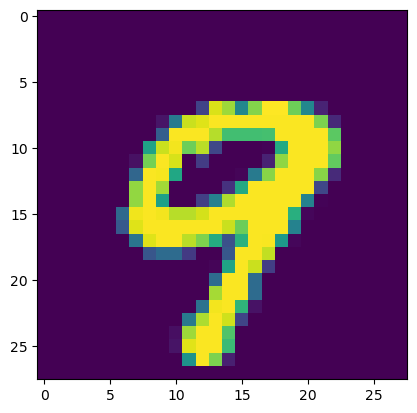

predict: 9
true:    9


In [62]:
result(model_conv, 'train')

Тестовая выборка, элемент № 1623


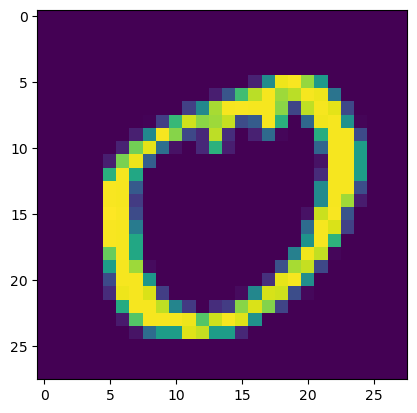

predict: 0
true:    0


In [63]:
result(model_conv, 'test')

Посчитаем количество неправильно предсказанных элементов на обучающей и на тестовой выборках

In [64]:
uncorrect_items = []
with torch.no_grad():
    model_conv.eval()
    for i in range(len(dataset_train)):
        target_predict = torch.argmax(model_conv(dataset_train.data[i].unsqueeze(0).unsqueeze(0).to(device).float())).squeeze().cpu().detach().tolist()
        target_true = dataset_train.targets[i].tolist()
        if target_predict != target_true:
            uncorrect_items.append(i)
print(f"Общее количество элементов обучающей выборки:                        {len(dataset_train)}")
print(f"Количество неправильно предсказанных элементов на обучающей выборке: {len(uncorrect_items)}")
print(f"Процент правильно предсказанных элементов на обучающей выборке:      {(1-len(uncorrect_items)/len(dataset_train)):.2%}")

Общее количество элементов обучающей выборки:                        60000
Количество неправильно предсказанных элементов на обучающей выборке: 400
Процент правильно предсказанных элементов на обучающей выборке:      99.33%


In [65]:
uncorrect_items = []
with torch.no_grad():
    model_conv.eval()
    for i in range(len(dataset_test)):
        target_predict = torch.argmax(model_conv(dataset_test.data[i].unsqueeze(0).unsqueeze(0).to(device).float())).squeeze().cpu().detach().tolist()
        target_true = dataset_test.targets[i].tolist()
        if target_predict != target_true:
            uncorrect_items.append(i)
print(f"Общее количество элементов тестовой выборки:                        {len(dataset_test)}")
print(f"Количество неправильно предсказанных элементов на тестовой выборке: {len(uncorrect_items)}")
print(f"Процент правильно предсказанных элементов на тестовой выборке:      {(1-len(uncorrect_items)/len(dataset_test)):.2%}")
print("Номера неправильно предсказанных элементов на тестовой выборке:")
print(uncorrect_items)

Общее количество элементов тестовой выборки:                        10000
Количество неправильно предсказанных элементов на тестовой выборке: 90
Процент правильно предсказанных элементов на тестовой выборке:      99.10%
Номера неправильно предсказанных элементов на тестовой выборке:
[8, 247, 358, 449, 543, 582, 674, 716, 740, 938, 947, 1039, 1112, 1232, 1247, 1319, 1364, 1522, 1611, 1621, 1681, 1686, 1737, 1773, 1790, 1878, 1901, 2018, 2035, 2040, 2070, 2118, 2129, 2130, 2182, 2266, 2343, 2369, 2414, 2597, 2654, 2896, 2927, 2939, 2953, 3062, 3073, 3225, 3289, 3384, 3451, 3457, 3475, 3520, 3534, 3558, 3601, 3626, 3808, 3818, 3906, 3926, 4176, 4400, 4443, 4477, 4507, 4571, 4639, 4731, 4740, 4761, 4783, 4807, 5331, 5937, 5955, 6572, 6625, 6783, 8325, 8376, 8408, 9009, 9015, 9664, 9729, 9749, 9770, 9850]


Выводы:
- метрика на обучающей выборке на моделях сопроставима;
- на тестовых данных сверточная сеть показывает значительно лучшее значение метрики